### Explanation
This code analyses time lapse images of plates with growing colonies and gets their size and mean fluorescence over time together with some valuable characterization of their dynamics. It uses the python module FluoPi to perform these tasks.

##### Requirements
 - All images have to be same size
 - Have _fluopi_ module installed (open Terminal in Mac or command line in Windows and type  `pip install fluopi`; more info [here](https://packaging.python.org/tutorials/installing-packages/) about installing python packages)


## Analysis

### Loading packages
As part of the [FluoPi](https://osf.io/dy6p2/) project we provide a python module to manage and analyse time lapse data. We will also use some common modules for plotting and analysing data:

In [5]:
# Import the FluoPi module
from fluopi import plotting as flup
from fluopi import analysis as flua
# import some useful packages to manage the data

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os.path

#modify some matplotlib parameters to manage the images for illustrator
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

### Loading Data

In this section you have to include the path of the data to be used. Be careful because it asumes you have the images in a subfolder in the same path as this notebook. If you have the images in another external folder you have to include the full path direction (e.g. _'C/myuser/.../my_images_folder'_)

If you downloaded all the github repository you should have the images in the subfolder _'Images/'_ and then the path should be up and ready.

Also, the example data can be obtained from the **_Files_** section in the [OSF FluoPi proyect](https://osf.io/dy6p2/). There you can download it from the *Google drive/Example_data/Size_and_fluo* folder. Moreover, there you can found other image series of your interest.

After specifying the folder name where the images are stored, we are able to count the files:

In [6]:
fpath = os.path.abspath('Images/Size_and_fluo/')
print(fpath)
imCount = flua.count_files(fpath, 'jpg')

# save the last image number name
lim=int(os.listdir(fpath)[-1].split('_')[-1].split('.')[0])

C:\Users\Prosimio\Documents\Fluopi\Examples\Images\Size_and_fluo
Size_and_fluo = 50 files


The _fluopi_ module provides a function to read images and save their values in 3-dimensional arrays (one for each channel). Now we can use this function to read and store the data of the images on a defined array for each channel:

In [7]:
import os
im_fname = os.path.join(fpath, 'image_%04d.jpg')

Frames = 1
#Frames=12   # use one image every 12 frames, uncomment if you use the original data

DataS={}
DataS['R'],DataS['G'],DataS['B'] = flua.get_im_data(Frames,imCount,im_fname)
DataS['Im']=im_fname     # to store the related image source

# also define a vector with the channels
channels=['R','G','B']

Finally is important know the time step value used on the timelapse. It can be known from the python timelapse hardware control code stored on the folder (named 'interval' in the code).

In [8]:
#define it in hour units
dT=1.0  # hours, in this example interval = 1 hour for each frame

#dT= 1.0/12.0  # hours, uncomment if you use the original paper data where interval = 5 min for each frame


With this, we can construct a **time vector** 'T' for *DataS*

In [9]:
w,h,st=DataS['R'].shape
T=np.zeros((st))
for i in range(0,st):
    T[i]=(i)*Frames*dT

print(T)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.
  45.  46.  47.  48.  49.]


### Data management

#### Background computation and substraction

To take the valuable data of images is good to know the amount of background we have on it, if it changes over time or how noisy is it.

By ploting a transect of pixel values for each channel on an image, we can figure the efect of background: 

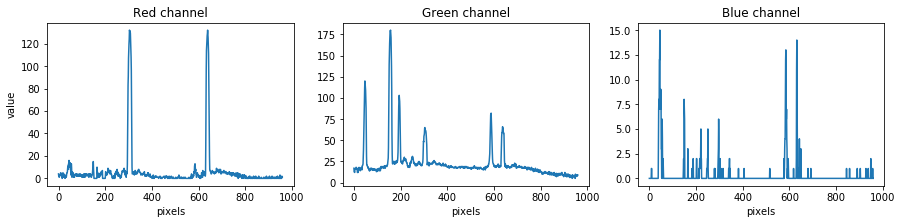

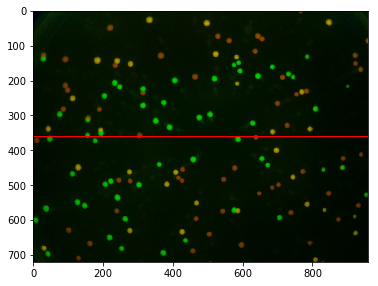

In [10]:
flup.row_transect(DataS, row=int(w/2), x_frames=Frames)

As you can see, data shows "peaks" (colonies) and a basal value along the line (background signal)

Then, to distinguish cell fluorescence from media and background light, we can select some empty sector on the image (i.e. without colonies) and compute his mean value on each frame.

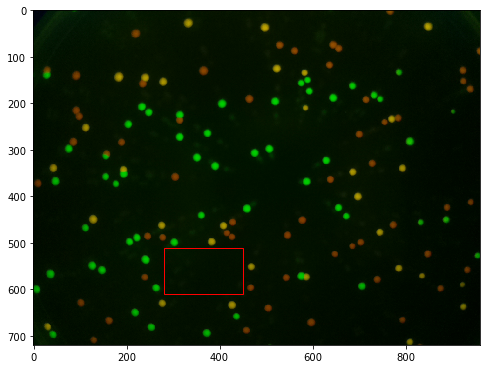

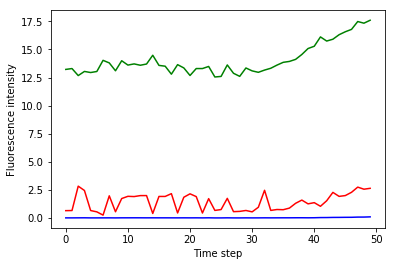

In [11]:
BG = flua.bg_value(512, 610, 280, 450, DataS, imCount)

We can substract this background value from each frame using BG_subst:

In [12]:
DataSB = flua.bg_subst(DataS,BG)

and we can check the effect on the background

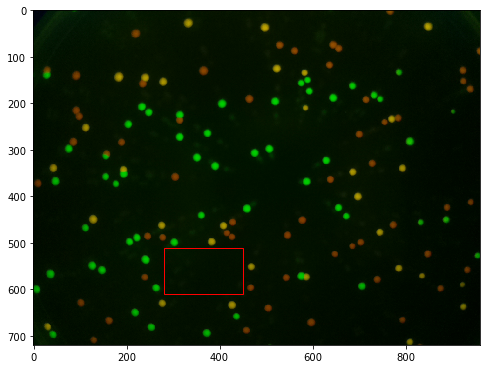

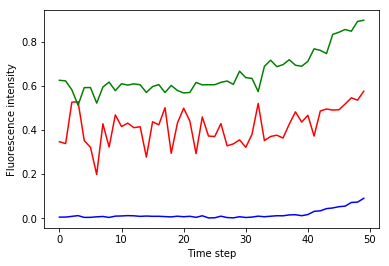

In [13]:
_ = flua.bg_value(512, 610, 280, 450, DataSB, imCount)

Background was practically eliminated.

### Get colony position
Here we are interested on identify the place where colonies are situated

A good way to do it is by sum the value of each pixel for all the channels and all the frames

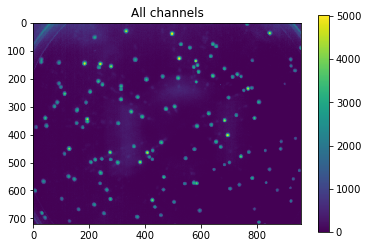

In [14]:
SumData = flua.data_sum_time(DataSB)

Now we can see each colony as a more clear point

#### Filter application
To improve the border detection and reduce the noise is recommended  to apply a filter to smooth the data. A simple and effective gaussian filter is provided by skimage package:
[skimage gaussian filter](http://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.gaussian)

In [15]:
from skimage.filters import gaussian

The effect of the filter can be understood with the next example:

In [16]:
#see the effect of the filter
a = np.zeros((3, 3))
a[1,1]=1
print('original: \n\n',a)
print('\nfiltered:')
gaussian(a, sigma=1)

original: 

 [[ 0.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  0.]]

filtered:


array([[ 0.05855018,  0.09653293,  0.05855018],
       [ 0.09653293,  0.15915589,  0.09653293],
       [ 0.05855018,  0.09653293,  0.05855018]])

Then we apply a the filter to the data (re-run the next line with different sigma values until you agree the smooth):

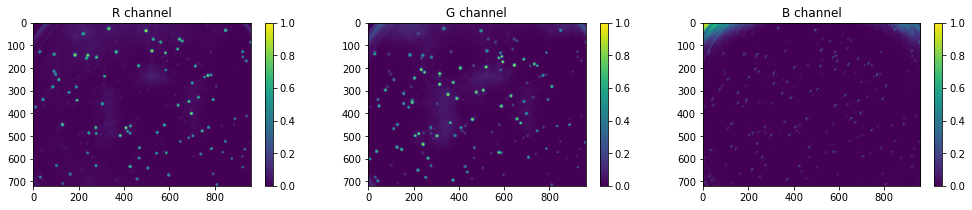

In [17]:
sDatS,sDatSall,sDatST=flua.smooth_data(DataSB,sigma=0.7)

And we can see the plot of the sumarized result

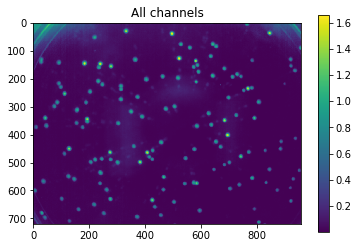

In [18]:
plt.imshow(sDatSall)
plt.colorbar()
plt.title('All channels')

#### Blob detection
Scikit-image provides several functions to detect Gaussian-like features ([blobs](http://scikit-image.org/docs/dev/auto_examples/plot_blob.html)). We apply one of these ([blob_log](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.blob_log)) to the smoothed sum of intensity, and it returns a list of position (x,y) and width (standard deviation):

To properly identification, it's important to set the **threshold value** for each dataset manually (_i.e._ Define it based on the previous colormap)

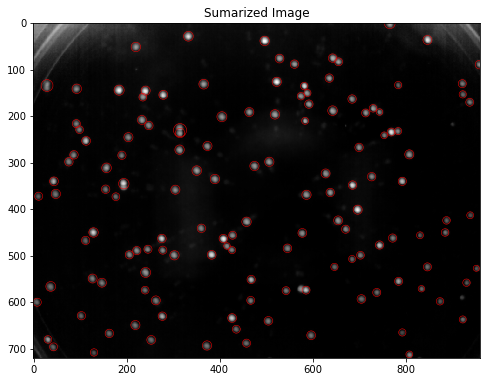

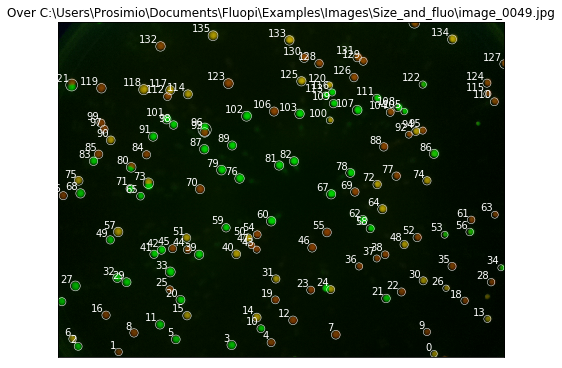

In [19]:
blobD = flua.colony_blobs_id(sDatSall,0.26,im_fname%(lim),filename='Plots/Size_and_fluo/DetectedBlobs')
# Threshold is the second argument e.g. 0.26

With the previous procedure we have identified where each colony is placed

To perform further analysis on each colony it is necesary to store these regions of interest (ROI) and his data, with size given by the Gaussian width (x2 = 2 standard deviations).

In [20]:
Rois,RoisC,NC = flua.obtain_rois(sDatST,blobD)

ROI x1 x2 y1 y2
0 705 719 801 816
ROI x1 x2 y1 y2
1 700 717 122 139
ROI x1 x2 y1 y2
2 687 706 34 53
ROI x1 x2 y1 y2
3 683 704 363 384
ROI x1 x2 y1 y2
4 679 698 449 468
ROI x1 x2 y1 y2
5 672 691 244 263
ROI x1 x2 y1 y2
6 672 689 23 40
ROI x1 x2 y1 y2
7 662 681 588 607
ROI x1 x2 y1 y2
8 658 677 154 173
ROI x1 x2 y1 y2
9 657 674 785 802
ROI x1 x2 y1 y2
10 649 668 427 446
ROI x1 x2 y1 y2
11 639 660 209 230
ROI x1 x2 y1 y2
12 631 650 496 515
ROI x1 x2 y1 y2
13 629 646 915 932
ROI x1 x2 y1 y2
14 625 644 418 437
ROI x1 x2 y1 y2
15 621 640 268 287
ROI x1 x2 y1 y2
16 620 639 94 113
ROI x1 x2 y1 y2
17 591 610 0 18
ROI x1 x2 y1 y2
18 590 607 866 883
ROI x1 x2 y1 y2
19 587 606 458 477
ROI x1 x2 y1 y2
20 586 607 253 274
ROI x1 x2 y1 y2
21 584 603 696 715
ROI x1 x2 y1 y2
22 570 589 729 748
ROI x1 x2 y1 y2
23 566 585 534 553
ROI x1 x2 y1 y2
24 565 584 577 596
ROI x1 x2 y1 y2
25 566 583 232 249
ROI x1 x2 y1 y2
26 564 579 827 842
ROI x1 x2 y1 y2
27 555 578 26 49
ROI x1 x2 y1 y2
28 550 567 923 940
ROI x

10 649 668 427 446
ROI x1 x2 y1 y2
11 639 660 209 230
ROI x1 x2 y1 y2
12 631 650 496 515
ROI x1 x2 y1 y2
13 629 646 915 932
ROI x1 x2 y1 y2
14 625 644 418 437
ROI x1 x2 y1 y2
15 621 640 268 287
ROI x1 x2 y1 y2
16 620 639 94 113
ROI x1 x2 y1 y2
17 591 610 0 18
ROI x1 x2 y1 y2
18 590 607 866 883
ROI x1 x2 y1 y2
19 587 606 458 477
ROI x1 x2 y1 y2
20 586 607 253 274
ROI x1 x2 y1 y2
21 584 603 696 715
ROI x1 x2 y1 y2
22 570 589 729 748
ROI x1 x2 y1 y2
23 566 585 534 553
ROI x1 x2 y1 y2
24 565 584 577 596
ROI x1 x2 y1 y2
25 566 583 232 249
ROI x1 x2 y1 y2
26 564 579 827 842
ROI x1 x2 y1 y2
27 555 578 26 49
ROI x1 x2 y1 y2
28 550 567 923 940
ROI x1 x2 y1 y2
29 548 569 137 158
ROI x1 x2 y1 y2
30 546 565 776 795
ROI x1 x2 y1 y2
31 542 561 459 478
ROI x1 x2 y1 y2
32 539 560 117 138
ROI x1 x2 y1 y2
33 525 548 230 253
ROI x1 x2 y1 y2
34 520 535 945 959
ROI x1 x2 y1 y2
35 515 534 838 857
ROI x1 x2 y1 y2
36 516 533 639 656
ROI x1 x2 y1 y2
37 499 516 677 694
ROI x1 x2 y1 y2
38 491 508 695 712
ROI x1 

we can ilustrate the data with the first blob (colony)

In [21]:
# show the first column of the first ROI
print(Rois['R'][0][:,1,1])
print(RoisC['R'][0][:,1,1]) #it contains only the pixels inside the circular region, and make the other equal to zero

[ 0.00333908  0.0171975   0.05077247  0.04343582  0.0616042   0.12283618
  0.28540822  0.11561304  0.18335065  0.71545135  0.9395649   0.3257922
  0.03810843  0.22435488]
[ 0.          0.          0.          0.          0.          0.
  0.28540822  0.11561304  0.18335065  0.          0.          0.          0.
  0.        ]


The ROI let us to track every colony in a seperatelly way. The module includes a package to save an image of a selected ROI (`idx`) at selected times (`Times`). Then is possible make timelapse grow of an indivial colony.

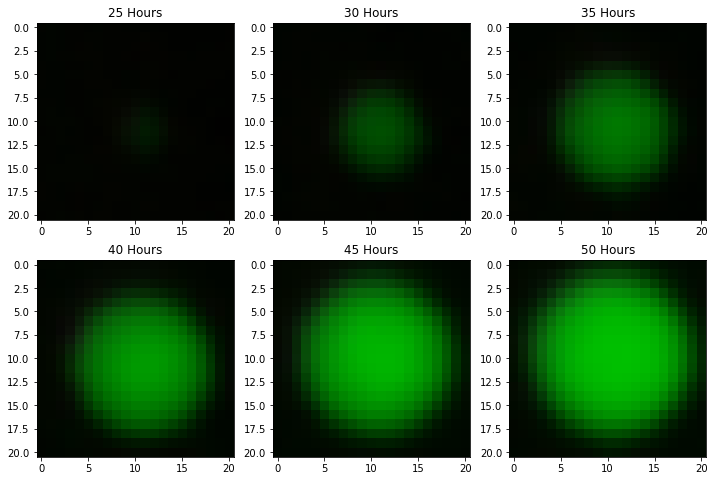

In [22]:
#Orange example
idx=79
fname=('ROIs/Col'+str(idx)+'_ROI_step%d.png')
Times=[24,29,34,39,44,49]       # this are positions on the time vector, not directly "times" (e.g. 24 = T[24] and not 24 h)

flup.tl_roi(Rois,idx,Times,fname,gridsize=[2,3])

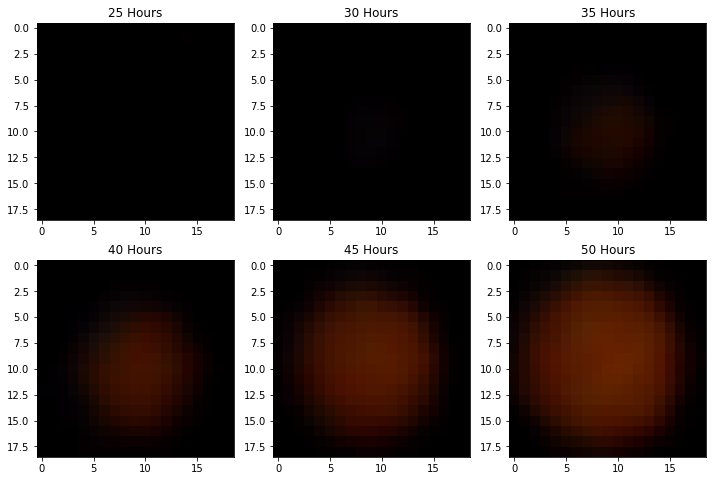

In [23]:
#Red example
idx=66
fname=('ROIs/Col'+str(idx)+'_ROI_step%d.png')
Times=[24,29,34,39,44,49]

flup.tl_roi(Rois,idx,Times,fname,gridsize=[2,3])

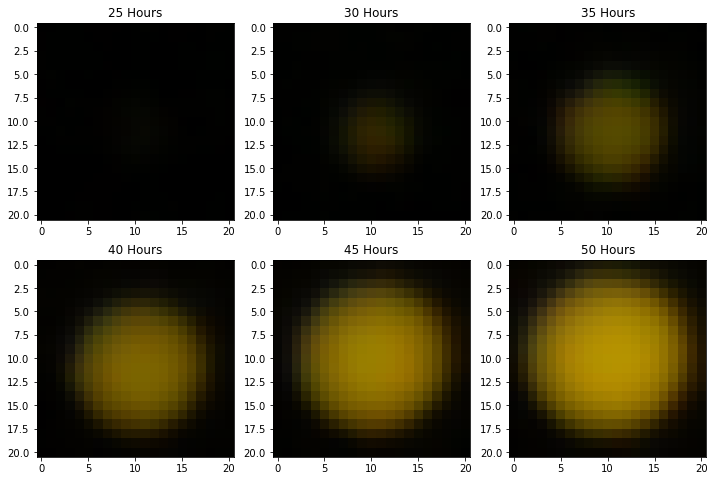

In [24]:
#Green example
idx=125
fname=('ROIs/Col'+str(idx)+'_ROI_step%d.png')
Times=[24,29,34,39,44,49]

flup.tl_roi(Rois,idx,Times,fname,gridsize=[2,3])

### Time dynamics of colonies
As we have estimated colony location (and maximmum size), we can analyse the dynamics of fluorescence and growth of them. 

#### Fluorescence dynamics
With the data obtained so far we can plot the fluorescence dynamics of colonies. We can choose some representative colonies and use the FluoPi `rois_plt_fluo_dynam()` function to perform this task:

Each line correspond to a different ROI


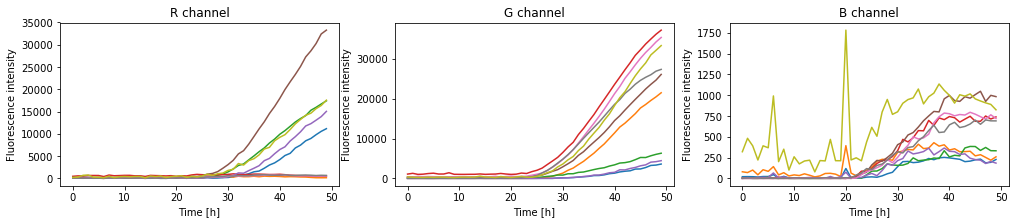

In [25]:
#define the selected colonies
Cols=[1,17,45,79,66,125,81,109,121]

#use the function to plot
#flup.rois_plt_fluo_dynam(RoisC,T,Cols)
flup.rois_plt_fluo_dynam(RoisC,T,Cols,filename='Plots/Size_and_fluo/Channel_total_intensity')

print('Each line correspond to a different ROI')

#### Colony radius growth
We have the location and a final size estimate based on the total fluorescence of each colony over the time-lapse. We would like to know the size of the colony in each frame; from this we can compute the growth rate.

One way to do this is to find Gaussian blobs in each of the image regions of the colony, for each frame of the time-lapse.This is very slow

First we perform the sum of all channels for each frame to get the best representation of colony size:

In [26]:
ACRois=flua.channels_sum(RoisC,Cols) #circular ROIS

In [27]:
ACRoisS=flua.channels_sum(Rois,Cols) #square ROIS

The following loop finds blobs and stores the width in each frame. The result is a dict containing the size at each time point for every colony

In [28]:
import time
start = time.time()
R_frame=flua.frame_colony_radius(ACRoisS,Cols,0.37)
end = time.time()
print(str(end - start)+' seg') #to know how long it takes to run

38.997230529785156 seg


Since the colony is roughly circular and flat, an estimate of volume is $R^2$. Lets plot this for some colonies. Plotting the log is useful because the slope is the relative growth rate. We can see the colonies slow their growth during the experiment.

Each line correspond to one colony


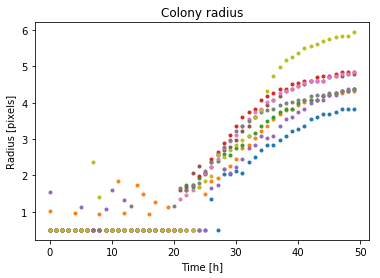

In [29]:
flup.plot_radius(R_frame, Cols, T)
print('Each line correspond to one colony')

#### Check the radius estimate
To see how well the colony size is estimated, we can compare to the profile of a colony in a slice of its image region. The radius (red line) should give the border of the colony.

c:\users\prosimio\anaconda3\envs\fluopy_online\lib\site-packages\fluopi\plotting.py:365: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if r_dots != 'null':


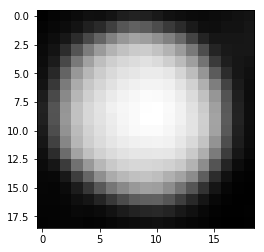

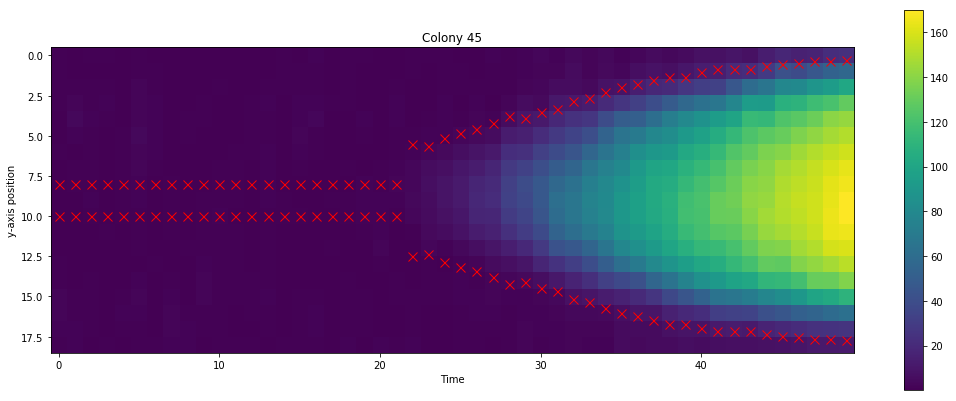

In [30]:
IDCol=Cols[2]
print()
plt.figure()
plt.imshow(ACRoisS[IDCol][:,:,-1], interpolation='none', cmap='gray')
#flup.check_radius(ACRoisS, IDCol, T, r_dots=R_frame[IDCol])
flup.check_radius(ACRoisS, IDCol, T, r_dots=R_frame[IDCol], filename='Plots/Size_and_fluo/Kymograph_'+str(IDCol))


##### Getting the colony area over time $A(t)$
with the radius value we are able to get the colony area over time by taking it as a perfect circle: $$A(t) = \pi \cdot r^{2}$$

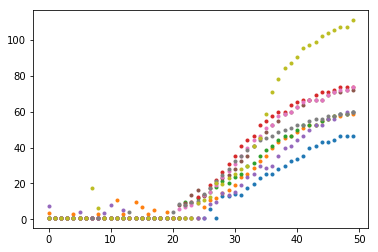

In [31]:
A=flua.area(R_frame,Cols,T)

To improve determination of radius we can fix a monotonically incresing function to the obstained values for each colony. This function could be of sigmodial type:
\begin{equation}
A(t) = \frac{a}{1+ e^{-d(t+b)}}
\end{equation}

where $a$ is the maximum area of the colony ($a = A_{max}$) and  $b$ is the time where the colony reach half of his maximum growth ($b = t_d$)

You can se the effect of the parameters evaluating the function F_logistic:

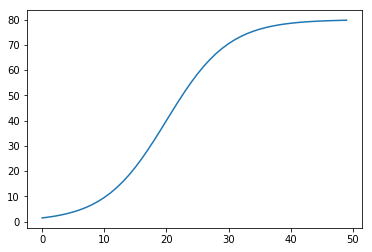

In [32]:
Sigmoid=flua.f_sigma(T, 80, -20, 0.2)
plt.plot(T,Sigmoid)

With the function `function_fit` you can fit a mathematical model (*F_sigma* by default) to one seleceted colony:

[ 60.99474717 -32.254453     0.19117199]


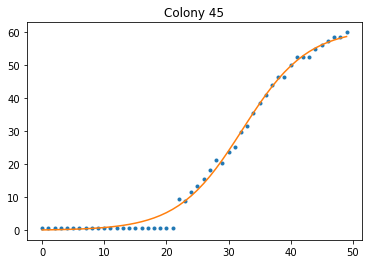

In [33]:
idx=Cols[2:3] # idx have to be an array, then to select one colony use this notation Cols[desired:desired+1]
init=20
end=-1
SingleF=flua.function_fit(T,A,init,end,idx)

or you can perform the fit to a dictionary of selected colonies with the same function:

[ 48.28460892 -35.2101951    0.21806907]


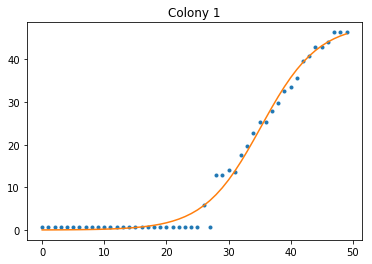

[ 58.43208321 -33.05391835   0.25041595]


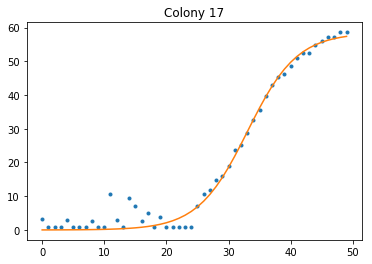

[ 61.59992248 -32.3550391    0.18479952]


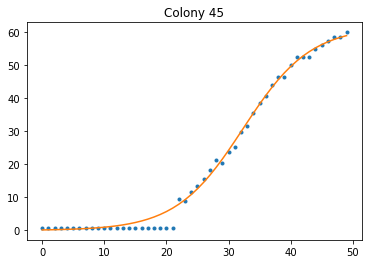

[ 72.67986294 -30.45511349   0.24613824]


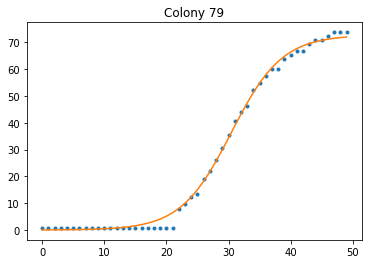

[ 62.58348732 -35.46071513   0.20983594]


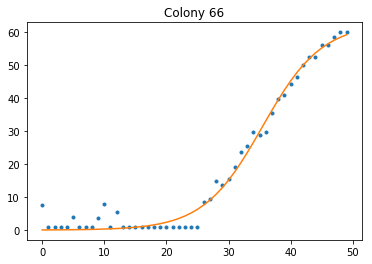

[ 75.21488548 -32.13028734   0.19630652]


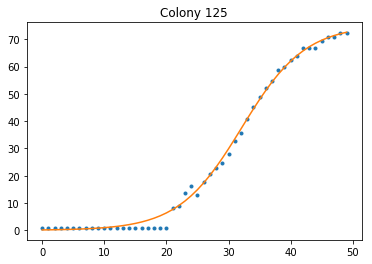

[ 72.22043425 -31.37547375   0.23167404]


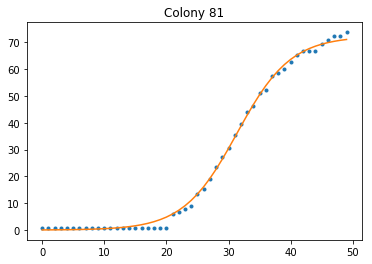

[ 57.84364881 -29.4092534    0.23602207]


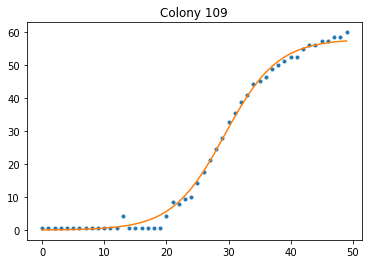

[ 110.43303906  -34.46650466    0.27523526]


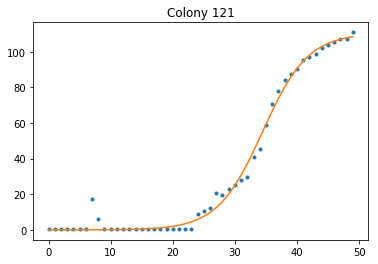

In [34]:
init=21
end=-1
A_fitS=flua.function_fit(T,A,init,end,Cols)

We can put alltogheter on one plot:

In [35]:
#set the color vector to have concordance between dots and fitted curves
colors = plt.cm.jet(np.linspace(0, 1, len(Cols))) #Paired o jet #https://matplotlib.org/users/colormaps.html


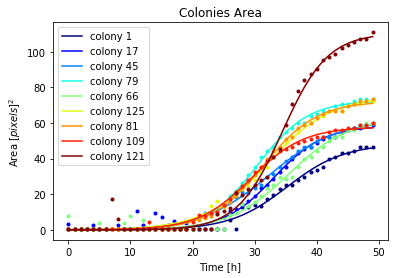

In [36]:
for i, c in zip(Cols, colors):
    plt.plot(T,A[i],'.',color=c)
    plt.plot(T,A_fitS[i][0],'-',color=c,label='colony '+str(i))

plt.xlabel('Time [h]')
plt.ylabel('Area $[pixels]^2$') 
plt.title('Colonies Area')
#plt.xlabel('Time [h]')
plt.legend(loc='upper left')
plt.savefig("Plots/Size_and_fluo/AreaFit.pdf", transparent=True)

With the area function we are able to back-compute the radius: $$ r (t) = \sqrt{\frac{A(t)}{\pi}} $$

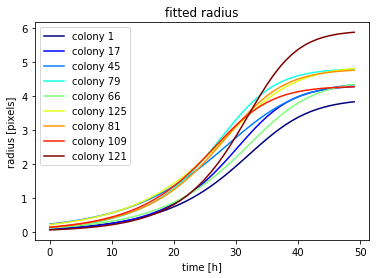

In [37]:
from math import pi
r_fit={}

plt.figure()
for i, c in zip(Cols, colors):
    r_fit[i]=(A_fitS[i][0]/pi)**(0.5)
    
    plt.plot(T,r_fit[i],'-',color=c,label='colony '+str(i))

plt.title('fitted radius')
plt.ylabel('radius [pixels]')
plt.xlabel('time [h]')
plt.legend(loc='upper left')
plt.savefig("Plots/Size_and_fluo/colonyRadiusFit.pdf", transparent=True)

We can plot it and the blob radius together:

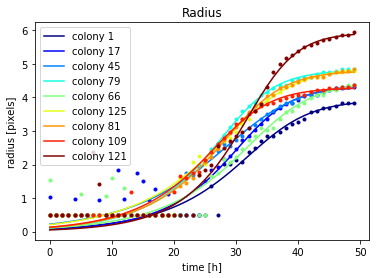

In [38]:
#fluopi.plot_radius(R_frame5,Cols,T)
for i, c in zip(Cols, colors):
    plt.plot(T,R_frame[i],'.',color=c)
    plt.plot(T,r_fit[i],'-',color=c,label='colony '+str(i))
plt.title('Radius')
plt.ylabel('radius [pixels]')
plt.xlabel('time [h]')
plt.legend(loc='upper left')
plt.savefig("Plots/Size_and_fluo/colonyRadiusFit_points.pdf", transparent=True)

Now we can check the radius estimation again:

c:\users\prosimio\anaconda3\envs\fluopy_online\lib\site-packages\fluopi\plotting.py:362: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if r_fit != 'null':
c:\users\prosimio\anaconda3\envs\fluopy_online\lib\site-packages\fluopi\plotting.py:365: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if r_dots != 'null':


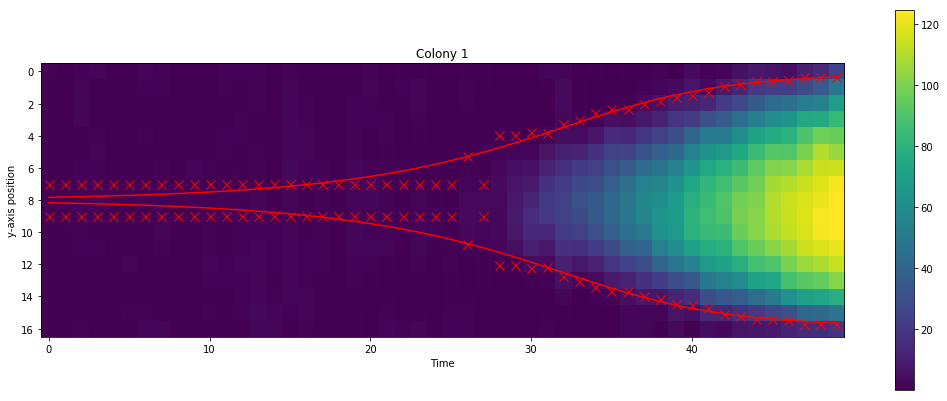

In [39]:
IDCol=int(Cols[0])
#flup.check_radius(ACRoisS,IDCol,T,r_fit=r_fit[IDCol],r_dots=R_frame[IDCol])
flup.check_radius(ACRoisS,IDCol,T,r_fit=r_fit[IDCol],r_dots=R_frame[IDCol],filename='Plots/Size_and_fluo/3Kymograph_fit2_color_'+str(IDCol))

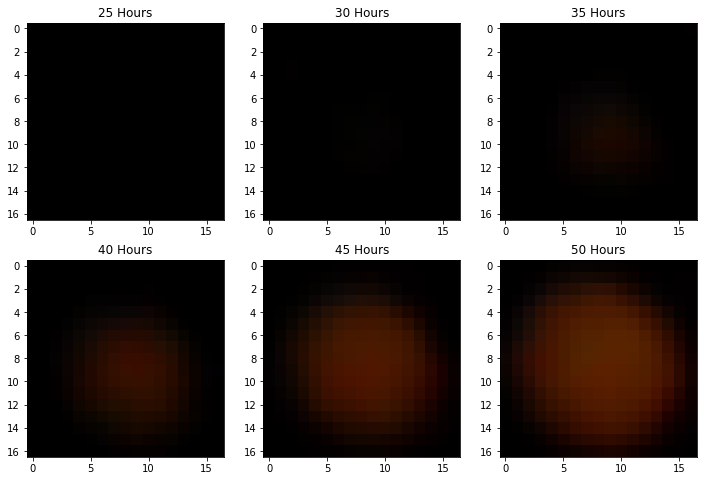

In [40]:
IDCol=Cols[0]
fname=('ROIs/sumCol'+str(IDCol)+'_ROI_step%d.pdf')
Times=[24,29,34,39,44,49]
flup.tl_roi(Rois,IDCol,Times,fname,radius=r_fit[IDCol], chan_sum=False, gridsize=[2,3]) 


colony grows stimation seems to get more cotinuous and improve greatly at the beginning.

### Parameter estimation from data

We now have information about sub-populations of bacteria (colonies) on the same plate. The fluorescence in each region of interest estimates the time varying fluorescent protein level in each colony. The radius (or $R^2$) approximates the size of each sub-population (colony) and so is similar to optical density (OD) in a bulk plate-reader experiment. 

Lets write a simple model of fluorescent protein expression from a single cell:

\begin{equation}
\frac{dF}{dt} = k(t) - (\mu(t) + \delta(t))F
\end{equation}

where $F$ is the cell's fluorescent protein concentration, which is produced at time-varying rate $k(t)$. The cell grows at relative rate $\mu(t)=(1/V)dV/dt$ ($V=$volume) causing dilution, but assuming a constant thickness of the colony it becomes proportional to the area: $\mu(t)=(1/A)dA/dt$ ($A=$area). 
The protein is degraded at rate $\delta(t)$.


For the proteins we are using we will assume that $\delta(t)=0$ for all times. We measure the total fluorescence intensity, which is the concentration $F$ multiplied by the total volume of the colony $A_{tot} = \pi R^2$. Hence,

\begin{equation}
I(t) = F(t)A(t) \approx F(t) \pi R^2(t)
\end{equation}

From these equations it is possible to derive (see [maths](https://github.com/SynBioUC/FluoPi/blob/5533704f41cf62f56551a40159e8ebd785a2b66b/Maths/Fluorescence%2Bmaths.pdf)) the fluorescent expresion rate constant could be represented by: $$ K_f = \frac{d(I/A)}{dt} + \mu \cdot (I/A) $$


To be able to estimate the value of this parameter we have to compute the values of each element in his representative equation.

To get an acurate analysis of the gener expression dynamics of the colonies, the module include a function to compute the average fluorescent value inside the limits of the colony (defined by the radius fitting) on each time. This average value correspond to $I/A$ (see the [maths](https://github.com/SynBioUC/FluoPi/blob/5533704f41cf62f56551a40159e8ebd785a2b66b/Maths/Fluorescence%2Bmaths.pdf))

In [41]:
MeanInt=flua.croi_mean_int_frames(sDatST,blobD,r_fit,Cols)

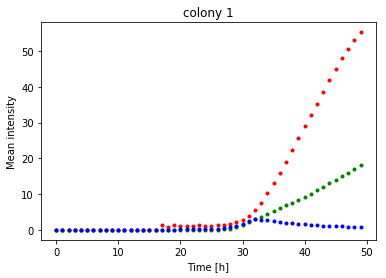

In [42]:
idx=Cols[0]
plt.plot(T,MeanInt['R'][idx],'.',color='r')
plt.plot(T,MeanInt['G'][idx],'.',color='g')
plt.plot(T,MeanInt['B'][idx],'.',color='b')
plt.ylabel('Mean intensity')
plt.xlabel('Time [h]')
plt.title('colony '+str(idx))

by sum the three channels we can get the total intensity per area $(I/A)_{total}$

In [43]:
#let's sum the three channels
MeanInt3C={}
for i in Cols:
    Vaux=np.zeros((MeanInt['R'][i].shape))
    for c in channels:
        Vaux+=MeanInt[c][i]
    
    MeanInt3C[i]= Vaux

this plot contain the sum of the mean of the three channels over time for each colony


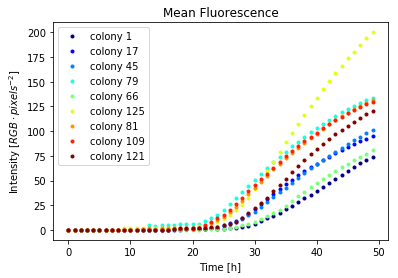

In [44]:
plt.figure()
for i, c in zip(Cols, colors):
    plt.plot(T,MeanInt3C[i],'.',color=c,label='colony '+str(i))

plt.title('Mean Fluorescence')
plt.xlabel('Time [h]')
plt.ylabel('Intensity $[RGB \cdot pixels^{-2}]$')
plt.legend(loc='upper left')
    
plt.savefig("Plots/Size_and_fluo/MeanInt.pdf", transparent=True)

print('this plot contain the sum of the mean of the three channels over time for each colony')

With that is possible to compute the derivative of this value: $ d(I/A)/dt $

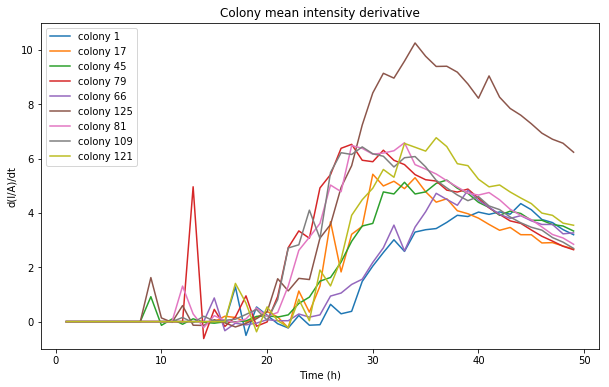

In [45]:
dIAdt_dis={}
plt.figure(figsize=(10,6))
for i in Cols:
    #delta_MeanInt3C is the intensity divided by the area = d(I/A)/dt
    delta_MeanInt3C = np.diff(MeanInt3C[i])
    delta_T=np.diff(T)
    dIAdt_dis[i] = delta_MeanInt3C/delta_T
    plt.plot(T[1:],dIAdt_dis[i],'-',label='colony '+str(i))
    plt.xlabel('Time (h)')
    plt.ylabel('d(I/A)/dt')
    plt.ylim([-1,11])
    plt.legend(loc='upper left')
    plt.title('Colony mean intensity derivative')

Finally, we should compute the $\mu(t)=(1/A)dA/dt$
, which under the sigmoideal growth moldel it's equal to: $$\mu = \frac{d}{e^{d \cdot (t+b)}+1} $$

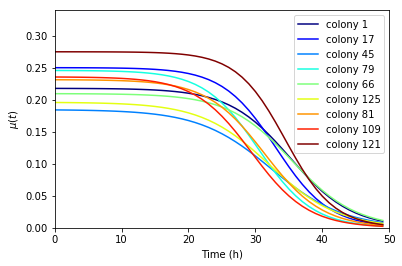

In [46]:
Mu_val={}
for i, c in zip(Cols, colors):
    Mu_val[i]=flua.f_mu(T,A_fitS[i][1][1],A_fitS[i][1][2])
    plt.plot(T,Mu_val[i],'-',color=c,label='colony '+str(i))
    plt.xlabel('Time (h)')
    plt.ylabel(r'$\mu (t)$')
    plt.xlim([0,50])
    plt.ylim([0,0.34])
    plt.legend(loc='upper right')
plt.savefig("Plots/Size_and_fluo/GrowthRate.pdf", transparent=True)


## Data smoothing

To perform an accurated estimation it's good to apply data smoothing.

In [47]:
from scipy.interpolate import UnivariateSpline

[Univariate Spline Documentation](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.interpolate.UnivariateSpline.html)

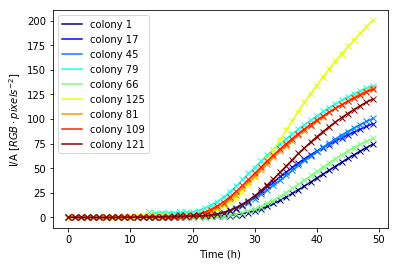

In [48]:
IA_smooth={}

for i, c in zip(Cols, colors):
    IA_smooth[i] = UnivariateSpline(T,MeanInt3C[i], k=3)   # k is the degree of the smoothing spline  (<=5)
    IA_smooth[i].set_smoothing_factor(10)
    plt.plot(T,IA_smooth[i](T[:]),'-',color=c, label='colony '+str(i))
    plt.plot(T,MeanInt3C[i],'x',color=c)
    plt.xlabel('Time (h)')
    plt.ylabel('I/A $[RGB \cdot pixels^{-2}]$')
    plt.legend(loc='upper left')
    #plt.ylim([-5,20])
    
plt.savefig("Plots/Size_and_fluo/IA_smooth.pdf", transparent=True)

From this smooth values of _IA_ we can compute his derivative:

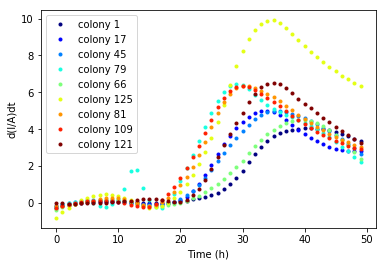

In [49]:
dIAdt={}
for i, c in zip(Cols, colors):
    dIAdt[i]=IA_smooth[i].derivative()   # k is the degree of the smoothing spline  (<=5)
    #dIAdt_smooth[i].set_smoothing_factor(55)
    plt.plot(T,dIAdt[i](T),'.',color=c, label='colony '+str(i))
plt.xlabel('Time (h)')
plt.ylabel('d(I/A)dt')
plt.legend(loc='upper left')
    #plt.ylim([-5,20])
    
plt.savefig("Plots/Size_and_fluo/d(IA)dt.pdf", transparent=True)

Or we can make the smooth of the previuos *dIAdt_dis* computed values:

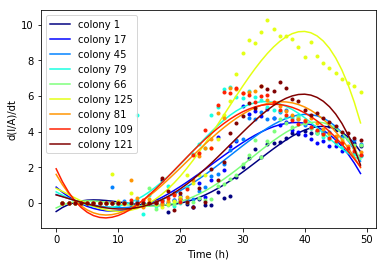

In [50]:
dIAdt_smooth={}

for i, c in zip(Cols, colors):
    dIAdt_smooth[i] = UnivariateSpline(T[1:],dIAdt_dis[i], k=4)   # k is the degree of the smoothing spline  (<=5)
    #dIAdt_smooth[i].set_smoothing_factor(55)
    plt.plot(T[:],dIAdt_smooth[i](T[:]),'-',color=c, label='colony '+str(i))
    plt.plot(T[1:],dIAdt_dis[i],'.',color=c)
    plt.xlabel('Time (h)')
    plt.ylabel('d(I/A)/dt')
    plt.legend(loc='upper left')
    #plt.ylim([-5,20])
    
plt.savefig("Plots/Size_and_fluo/d(IA)dT_smooth.pdf", transparent=True)
    

Finally, the fluorescent expresion rate constant could be represented by: $$ K_f = \frac{d(I/A)}{dt} + \mu \cdot (I/A) $$

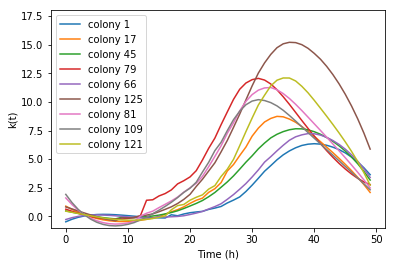

In [51]:
Kf={}
for i, c in zip(Cols, colors):
    Kf[i]=dIAdt_smooth[i](T[:])+Mu_val[i]*MeanInt3C[i]
    plt.plot(T[:],Kf[i],'-',label='colony '+str(i))
    plt.xlabel('Time (h)')
    plt.ylabel('k(t)')
    plt.ylim([-1,18])
    plt.legend(loc='upper left')
plt.savefig("Plots/Size_and_fluo/K_dynamics.pdf", transparent=True)